# Transfer Learning EfficientNetB0 

In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import decode_predictions, preprocess_input


# Loading a new dataset Stanford dogs

In [24]:
# !pip install tensorflow_datasets
# maybe you have to add in the powershell before
# New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" `-Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force
import tensorflow_datasets as tfds

IMG_SIZE = 224  # IMG_SIZE is determined by EfficientNet model choice
batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes
print(NUM_CLASSES)
print(type(ds_train))

120
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


## Show some examples

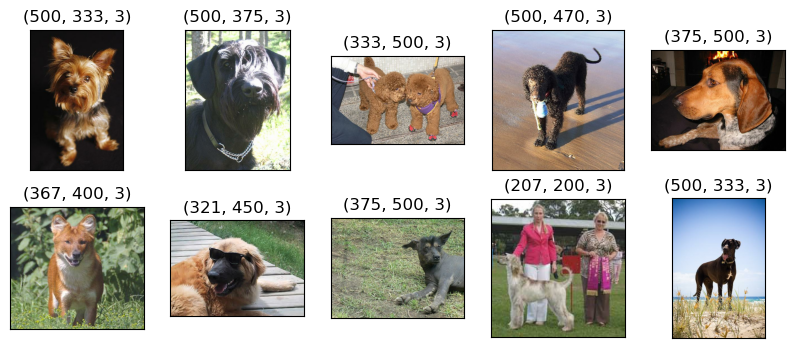

In [26]:
import matplotlib.pyplot as plt

datalist = list(ds_train)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for index in range(10):
    x,y = datalist[index]
    ax=axs[index%2, int(index/2)] 
    ax.imshow(x)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"{x.shape}")

In [27]:
import tensorflow as tf
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [28]:
# write a function that can plot the name given a class-index
label_info = ds_info.features["label"]
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

format_label(0)


'chihuahua'

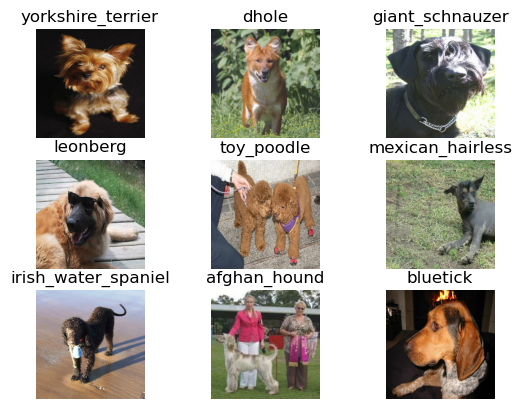

In [32]:
# plot 9 samples
import matplotlib.pyplot as plt
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(image.numpy().astype("uint8"))
    plt.title(f"{format_label(label)}")
    plt.axis("off")


In [35]:
tf.get_logger().setLevel('WARNING') 
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [36]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [37]:
model = build_model(num_classes=NUM_CLASSES)
epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)


Epoch 1/25
187/187 - 91s - loss: 1.8317 - accuracy: 0.6779 - val_loss: 0.8433 - val_accuracy: 0.7771 - 91s/epoch - 488ms/step
Epoch 2/25
187/187 - 81s - loss: 0.6528 - accuracy: 0.8396 - val_loss: 0.9531 - val_accuracy: 0.7905 - 81s/epoch - 431ms/step
Epoch 3/25
187/187 - 81s - loss: 0.3789 - accuracy: 0.8916 - val_loss: 0.9148 - val_accuracy: 0.8092 - 81s/epoch - 433ms/step
Epoch 4/25
187/187 - 81s - loss: 0.2932 - accuracy: 0.9112 - val_loss: 1.0131 - val_accuracy: 0.8035 - 81s/epoch - 434ms/step
Epoch 5/25
187/187 - 80s - loss: 0.2696 - accuracy: 0.9193 - val_loss: 1.0702 - val_accuracy: 0.8060 - 80s/epoch - 430ms/step
Epoch 6/25
187/187 - 81s - loss: 0.2629 - accuracy: 0.9220 - val_loss: 1.1454 - val_accuracy: 0.7951 - 81s/epoch - 431ms/step
Epoch 7/25
187/187 - 80s - loss: 0.3059 - accuracy: 0.9128 - val_loss: 1.2145 - val_accuracy: 0.7950 - 80s/epoch - 430ms/step
Epoch 8/25
187/187 - 81s - loss: 0.2756 - accuracy: 0.9181 - val_loss: 1.2824 - val_accuracy: 0.7962 - 81s/epoch - 431

In [ ]:
plot_hist(hist)